# CLSmith Results

To generate results:

```
# make programs
$ ./mkprograms -H cc1 -n 10000
# list available OpenCL platforms and devices
$ ./clinfo
# run programs on platform ID and device ID
$ ./runprograms -H cc1 0 0
```

Connect to results database:

In [1]:
import db
from db import Program, Testbed, Params, Result, Session

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/clsmith'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

data = []
data.append(("Programs", session.query(Program).count()))
data.append(("Testbeds", session.query(Testbed).count()))
data.append(("Params", session.query(Params).count()))
data.append(("Results", session.query(Result).count()))

pd.DataFrame(data, columns=["", "Count"])

,,Count
0,Programs,10001
1,Testbeds,2
2,Params,4
3,Results,80008


### TestBeds

In [3]:
DEVICES = {
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620"
}

testbeds = []
for testbed in session.query(Testbed):
    nresult_tb = session.query(Result).filter(Result.testbed_id == testbed.id).count()
    ratio_result = "{:.2%}".format(nresult_tb / session.query(Result).count())
    testbeds.append((testbed.id, DEVICES.get(testbed.device, testbed.device),
                     testbed.driver, testbed.host, nresult_tb, ratio_result))
    
pd.DataFrame(testbeds, columns=["ID", "Name", "Driver", "Host", "#. of Results", "% of Total Results"])

,ID,Name,Driver,Host,#. of Results,% of Total Results
0,3,NVIDIA GTX 1080,375.39,Ubuntu 16.04 64bit,40004,50.00%
1,9,Intel E5-2620,1.2.0.25,Ubuntu 16.04 64bit,40004,50.00%


### Parameters

In [4]:
params = []
for param in session.query(Params).order_by(
        Params.gsize_x, Params.gsize_y, Params.gsize_z,
        Params.lsize_x, Params.lsize_y, Params.lsize_z, Params.optimizations):
    nresult_param = session.query(Result).filter(Result.params_id == param.id).count()
    ratio_result = "{:.2%}".format(nresult_param / session.query(Result).count())
    print(param)
    params.append((param.id, param.gsize, param.lsize, param.optimizations_on_off, nresult_param, ratio_result))

pd.DataFrame(params, columns=["ID", "Global size", "Local size", "Optimizations", "#. of Results", "% of Total Results"])

Optimizations: off, Global size: (1, 1, 1), Local size: (1, 1, 1)
Optimizations: on, Global size: (1, 1, 1), Local size: (1, 1, 1)
Optimizations: off, Global size: (128, 16, 1), Local size: (32, 1, 1)
Optimizations: on, Global size: (128, 16, 1), Local size: (32, 1, 1)


,ID,Global size,Local size,Optimizations,#. of Results,% of Total Results
0,4,"(1, 1, 1)","(1, 1, 1)",off,20002,25.00%
1,3,"(1, 1, 1)","(1, 1, 1)",on,20002,25.00%
2,2,"(128, 16, 1)","(32, 1, 1)",off,20002,25.00%
3,1,"(128, 16, 1)","(32, 1, 1)",on,20002,25.00%


### Result Exit Status

In [5]:
failures = {}

def get_error_type(stderr) -> str:
    for line in reversed(stderr.split('\n')):
        if line.startswith("Error "):
            return line
    else:
        raise LookupError

q = session.query(Result.id, Result.stderr).filter(Result.status == 1)
failures = dict((tid, get_error_type(stderr)) for tid, stderr in q)

failure_types = pd.DataFrame(pd.Series(list(failures.values())).value_counts(), columns=["Count"])
failure_types

,Count
Error building program: -11,9044
Error enqueueing kernel: -5,1382
Error sending finish command: -36,281
Error creating kernel: -46,160
Error found (callback):,101
Error enqueueing kernel: -6,3


In [45]:
# set outcomes
session.rollback()
def get_outcome(result):
    if result.status == 1:
        prev = None
        for line in reversed(result.stderr.split('\n')):
            if line == "Error found (callback):":
                # Interpret CLSmith error callback messages:
                return prev.split()[0]
            elif line.startswith("Error"):
                # Interpret CLSmith error messages
                return {
                    "Error enqueueing kernel: -6": "CL_OUT_OF_HOST_MEMORY",
                    "Error sending finish command: -36": "CL_INVALID_COMMAND_QUEUE",
                    "Error building program: -11": "CL_BUILD_PROGRAM _FAILURE",
                    "Error creating kernel: -46": "CL_INVALID_KERNEL_NAME",
                    "Error enqueueing kernel: -5": "CL_OUT_OF_RESOURCES",
                }.get(line, line)
            prev = line
        else:
            raise LookupError
    else:
        # Interpret process status codes:
        return {
            -11: "Segmentation Fault",
            -9: "Timeout (60 seconds)",
            0: "Okay",
        }[result.status]

for result in session.query(Result):
    result.outcome = get_outcome(result)
session.commit()
print("done.")

done.


In [46]:
import sqlalchemy as sql

outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(Result).filter(Result.testbed == testbed).count()

    q = session.query(Result.outcome, sql.func.count(Result.outcome)).filter(
        Result.testbed == testbed).group_by(Result.outcome).order_by(sql.desc(sql.func.count(Result.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        outcomes.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))

outcomes = pd.DataFrame(outcomes, columns=["Device", "Outcome", "Count", "% of Total Results"])
outcomes

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout (60 seconds),3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout (60 seconds),3311,8.276672


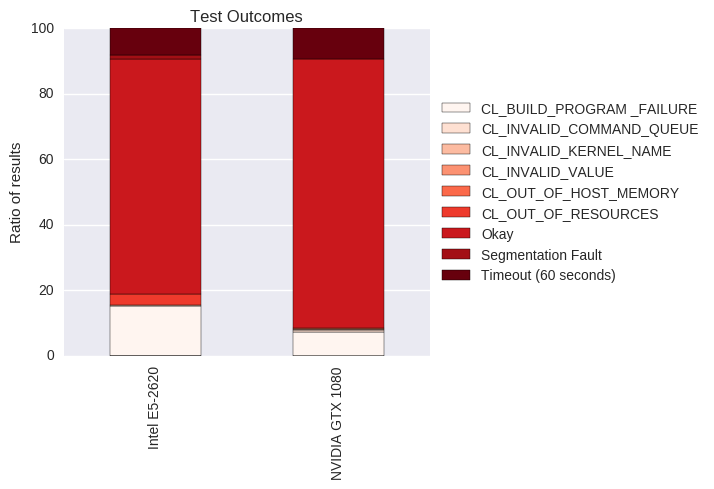

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

palette = sns.cubehelix_palette(4, rot=-.4, light=.85, dark=.35)


ax = outcomes.pivot('Device', 'Outcome')['% of Total Results'].plot(kind='bar', stacked=True, colormap='Reds')

plt.title("Test Outcomes")
plt.ylabel("Ratio of results")
plt.xlabel("")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

viz.finalise(figsize=(4.5, 5))

In [9]:
for param in session.query(db.Params).all():
    suspicious = []

    print("Params:", param)
    programs_with_results = session.query(db.Program).filter(
        db.Program.id.in_(session.query(db.Result.program_id).filter(db.Result.params_id == param.id)))
    programs_with_good_results = session.query(db.Program).filter(
        db.Program.id.in_(session.query(db.Result.program_id).filter(
            db.Result.params_id == param.id, db.Result.status == 0)))
    ratio_good = programs_with_good_results.count() / programs_with_results.count()

    print("  #. programs with results", programs_with_results.count())
    print("  #. programs with good results", programs_with_good_results.count(), f"({ratio_good:.1%} of total)")

    for program in programs_with_good_results.all():
        q = session.query(db.Result).filter(
                db.Result.program_id == program.id, db.Result.params_id == param.id)

        stdout = set(r.stdout for r in q.all())
        if len(stdout) > 1:
            suspicious.append(q.first().program_id)

    nsuspicious = len(suspicious)
    ratio_suspicious = nsuspicious / programs_with_good_results.count()
    print(f"  #. suspicious {nsuspicious} ({ratio_suspicious:.1%} of total)\n")

Params: Optimizations: off, Global size: (1, 1, 1), Local size: (1, 1, 1)
  #. programs with results 10001
  #. programs with good results 8282 (82.8% of total)
  #. suspicious 877 (10.6% of total)

Params: Optimizations: off, Global size: (128, 16, 1), Local size: (32, 1, 1)
  #. programs with results 10001
  #. programs with good results 8211 (82.1% of total)


KeyboardInterrupt: 